### Import packages

In [1]:
from helper_fns import *

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

from scipy.optimize import minimize, brentq

In [3]:
seed = 12345

### Load dataset

In [4]:
fraud_data = pd.read_csv("data/Fraud_detection/creditcard.csv")

### Data processing

Text(0, 0.5, 'Frequency')

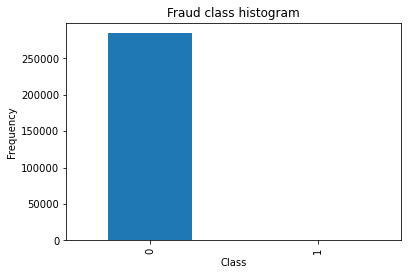

In [5]:
count_classes = pd.value_counts(fraud_data['Class'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [6]:
fraud_data['normAmount'] = StandardScaler().fit_transform(np.array(fraud_data['Amount']).reshape(-1, 1))
fraud_data = fraud_data.drop(['Time','Amount'],axis=1)

In [7]:
X = fraud_data.iloc[:, fraud_data.columns != 'Class']
y = fraud_data.iloc[:, fraud_data.columns == 'Class']

In [8]:
n_total = len(y)
n_train = int(round(0.7*n_total))
n_test = n_total - n_train

In [9]:
n_trials = 100

In [10]:
train_inds, test_inds = generate_data_for_trials(n_trials, n_train, n_total)

In [11]:
def data_processing(X, y, train_inds, test_inds, trial_number):
    
    X_train = X.iloc[train_inds[trial_number],:]
    y_train = y.iloc[train_inds[trial_number],:]
    X_test = X.iloc[test_inds[trial_number],:]
    y_test = y.iloc[test_inds[trial_number],:]
    
    train_data = pd.concat([X_train, y_train], axis = 'columns').reset_index(drop = True)
    test_data = pd.concat([X_test, y_test], axis = 'columns').reset_index(drop = True)
    
    # Number of data points in the minority class
    number_records_fraud = len(train_data[train_data.Class == 1])

    #Picking indices of fraud and normal cases
    fraud_indices = np.array(train_data[train_data.Class == 1].index)
    normal_indices = train_data[train_data.Class == 0].index

    # Out of the indices we picked, randomly select "x" number (number_records_fraud)
    random_normal_indices = np.array(np.random.choice(normal_indices, number_records_fraud, replace = False))

    # Under sample dataset
    under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])
    random.shuffle(under_sample_indices)
    under_sample_data = train_data.iloc[under_sample_indices,:]

    X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
    y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']
    
    X_train_undersample, X_cal_undersample, \
    y_train_undersample, y_cal_undersample = train_test_split(X_undersample, y_undersample,
                                                           test_size = 0.5, random_state = seed)
    
    return X_train_undersample, X_cal_undersample, y_train_undersample, y_cal_undersample, X_test, y_test

In [12]:
X_train_undersample = []
X_cal_undersample = []
y_train_undersample = [] 
y_cal_undersample = []
X_test = []
y_test = []

for i in range(n_trials):
    temp1, temp2, temp3, temp4, temp5, temp6 = data_processing(X, y, train_inds, test_inds, i)
    X_train_undersample.append(temp1)
    X_cal_undersample.append(temp2)
    y_train_undersample.append(temp3)
    y_cal_undersample.append(temp4)
    X_test.append(temp5)
    y_test.append(temp6)

### CV on undersampled data

In [13]:
# lr = LogisticRegression(max_iter = 1000) 

# param_grid = {'C': [0.01, 0.1, 1, 10, 100]}

# # 10-Fold Cross validation
# grid_clf = GridSearchCV(lr, param_grid, cv = 10)
# grid_clf.fit(X_train_undersample, y_train_undersample.values.ravel())

# best_c = grid_clf.best_params_['C']
best_c = 1

### Model fit results

In [15]:
def pred_results_by_trial(n_trials, best_c, X_train_undersample, X_cal_undersample, y_train_undersample, y_cal_undersample):

    cal_gt_by_trial = []
    cal_sgmd_by_trial = []

    for i in tqdm.tqdm(range(n_trials)):
        
        lr = LogisticRegression(C = best_c)
        lr.fit(X_train_undersample[i], y_train_undersample[i].values.ravel())
        
        cal_gt = y_cal_undersample[i].values.ravel()
        cal_sgmd = lr.predict_proba(X_cal_undersample[i])
        
        cal_gt_by_trial.append(cal_gt)
        cal_sgmd_by_trial.append(cal_sgmd)
        
    return cal_gt_by_trial, cal_sgmd_by_trial

In [14]:
def alphahat_threshold(lam, risk_type, cal_sgmd, cal_gt, alpha): 
    
    n = len(cal_gt)
    
    filtered_indices = [np.where(row > lam)[0] for row in cal_sgmd]
    
    if (risk_type == 'FNR'):
        label = 1
    elif (risk_type == 'FPR'): 
        label = 0
    else:
        print('undefined risk type')
    
    flag = []
    for i in range(n):
        flag.append(np.logical_and(cal_gt[i] not in filtered_indices[i], cal_gt[i] == label))
        
    risk = sum(flag)/len(cal_gt[cal_gt == label])
    risk_metric = risk - ((n+1)/n*alpha - 1/(n+1))
    
    return risk_metric

In [17]:
def risk_by_lambda(lam, cal_sgmd_by_trial, cal_gt_by_trial):
    
    FNR = []
    FPR = []

    for i in range(n_trials):
        FNR.append(brentq(lambda alpha: alphahat_threshold(lam, 'FNR', cal_sgmd_by_trial[i], cal_gt_by_trial[i], alpha), 0, 1))
        FPR.append(brentq(lambda alpha: alphahat_threshold(lam, 'FPR' ,cal_sgmd_by_trial[i], cal_gt_by_trial[i], alpha), 0, 1))

    return FNR, FPR

In [18]:
def set_size_by_threshold(lam, cal_sgmd_by_trial): 
    
    set_size_by_trial = []
    
    for i in range(n_trials):
        
        filtered_indices = [np.where(row > lam)[0] for row in cal_sgmd_by_trial[i]]
        set_size = [len(set) for set in filtered_indices]
        set_size_by_trial.append(sum([set_size_entry == 2 for set_size_entry in set_size]))
    
    return np.mean(set_size_by_trial)

In [16]:
cal_gt_by_trial, cal_sgmd_by_trial = pred_results_by_trial(\
                                        n_trials, best_c, X_train_undersample, X_cal_undersample, \
                                                            y_train_undersample, y_cal_undersample)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 77.34it/s]


In [20]:
N = 11
lam_space = np.linspace(0, 1, N) 

set_size_by_lam = []
FNR_by_lam = []
FPR_by_lam = []
    
for i in range(N):
    set_size_by_lam.append(set_size_by_threshold(lam_space[i], cal_sgmd_by_trial))
    temp1, temp2 = risk_by_lambda(lam_space[i], cal_sgmd_by_trial, cal_gt_by_trial)
    FNR_by_lam.append(temp1)
    FPR_by_lam.append(temp2)

In [69]:
default_index = int(np.where(lam_space == 0.5)[0])

FNR = FNR_by_lam[default_index]
FPR = FPR_by_lam[default_index]

In [79]:
def risk_rate_by_type(FNR, FPR):
    
    risk_data = pd.DataFrame([FNR, FPR]).T.rename(columns = {0: 'FNR', 1: 'FPR'})
    
    sns.boxplot(x = "variable", 
                y = "value",
                data = pd.melt(risk_data),
                color = "steelblue")
    
    plt.ylabel('Error rate')
    plt.xlabel('Risk type')
    plt.title('Error rate by risk type')

    plt.savefig('error_rate_by_type.png')
    
    return None

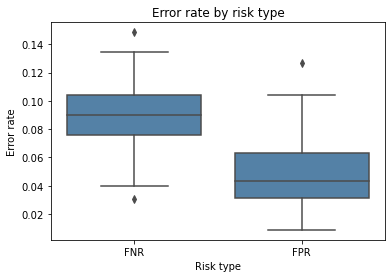

In [80]:
risk_rate_by_type(FNR, FPR)

In [46]:
def risk_rate_by_threshold(error_type, FNR_by_lam, FPR_by_lam):
    
    index_set = {0:'0.0', 1:'0.1', 2:'0.2', 3:'0.3',  4:'0.4', 5:'0.5', 
                    6:'0.6', 7:'0.7', 8:'0.8', 9:'0.9',  10:'1.0'}
    
    risk_data = pd.DataFrame(eval(error_type + '_by_lam')).T.rename(columns = index_set)
    risk_data = risk_data[risk_data.columns[1:10]]
    
    sns.boxplot(x = "variable", 
                y = "value",
                data = pd.melt(risk_data),
                color = "steelblue")
    
    plt.ylabel(error_type)
    plt.xlabel('Threshold')
    plt.ylim([0, 0.4])
    plt.title(error_type + ' by threshold')

    plt.savefig(error_type + '_by_threshold.png')
    
    return None

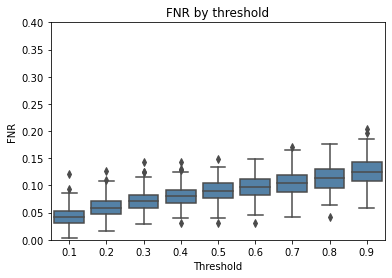

In [47]:
risk_rate_by_threshold('FNR', FNR_by_lam, FPR_by_lam)

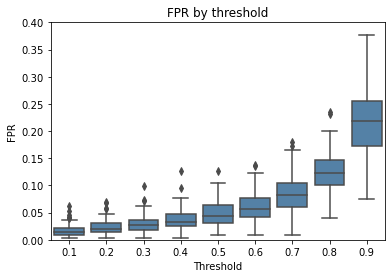

In [48]:
risk_rate_by_threshold('FPR', FPR_by_lam, FPR_by_lam)

In [49]:
avg_FNR_by_lam = np.mean(np.array(FNR_by_lam), axis = 1)
avg_FPR_by_lam = np.mean(np.array(FPR_by_lam), axis = 1)